In [5]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [6]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-26 15:52:50,867: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [8]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 5
numQubit = 2
global iterations
global noisy

In [9]:
'''
Defining -iX and iX needed to create group elements.
'''
mix = QuantumCircuit(1)
mix.rx(np.pi, 0)

ix = QuantumCircuit(1)
ix.rx(3*np.pi, 0)

In [11]:
'''
Defining -iY needed to create group elements.
'''
miy = QuantumCircuit(1)
miy.ry(np.pi, 0)

In [12]:
'''
Defining -iZ and iZ needed to create group elements.
'''
miz = QuantumCircuit(1)
miz.rz(np.pi, 0)

iz = QuantumCircuit(1)
iz.rz(3*np.pi, 0)

In [14]:
'''
Defining -iI needed to create group elements.
'''
mi = QuantumCircuit(1)
mi.rz(2*np.pi, 0)

In [17]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

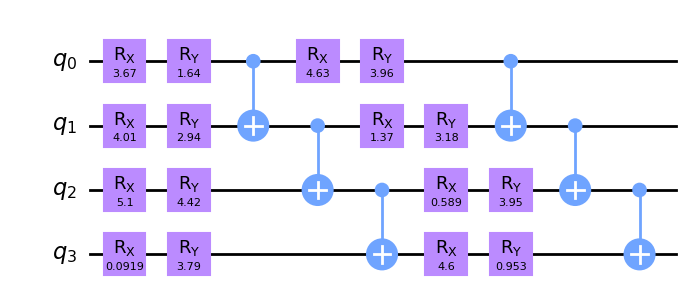

In [20]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 4
layers = 2
for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [21]:
def createEqSuperposQuaternion():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(3)
    temp.h(0)
    temp.h(1)
    temp.h(2)
    return temp

In [22]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix F from https://arxiv.org/pdf/2105.12758
    The ciruit contains 7 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(7)
    
    superPosCircuit = createEqSuperposQuaternion()
    circ.append(superPosCircuit, [0, 1, 2])
    circ.append(state, [3, 4, 5, 6])

    prover = createProver(numQubit, numLayer)
    circ.append(prover, [5, 6])
    
    custom = miz.to_gate().control(2)
    circ.append(custom, [0, 3, 4])
    custom = iz.to_gate().control(2)
    circ.append(custom, [0, 5, 6])
    
    custom = miy.to_gate().control(2)
    circ.append(custom, [1, 3, 4])
    circ.append(custom, [1, 5, 6])

    custom = mix.to_gate().control(2)
    circ.append(custom, [2, 3, 4])
    custom = ix.to_gate().control(2)
    circ.append(custom, [2, 5, 6])

    circ.x(0)
    custom = mi.to_gate().control(3)
    circ.append(custom, [0, 2, 3, 4])
    circ.append(custom, [0, 2, 5, 6])
    circ.x(0)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])

    return circ

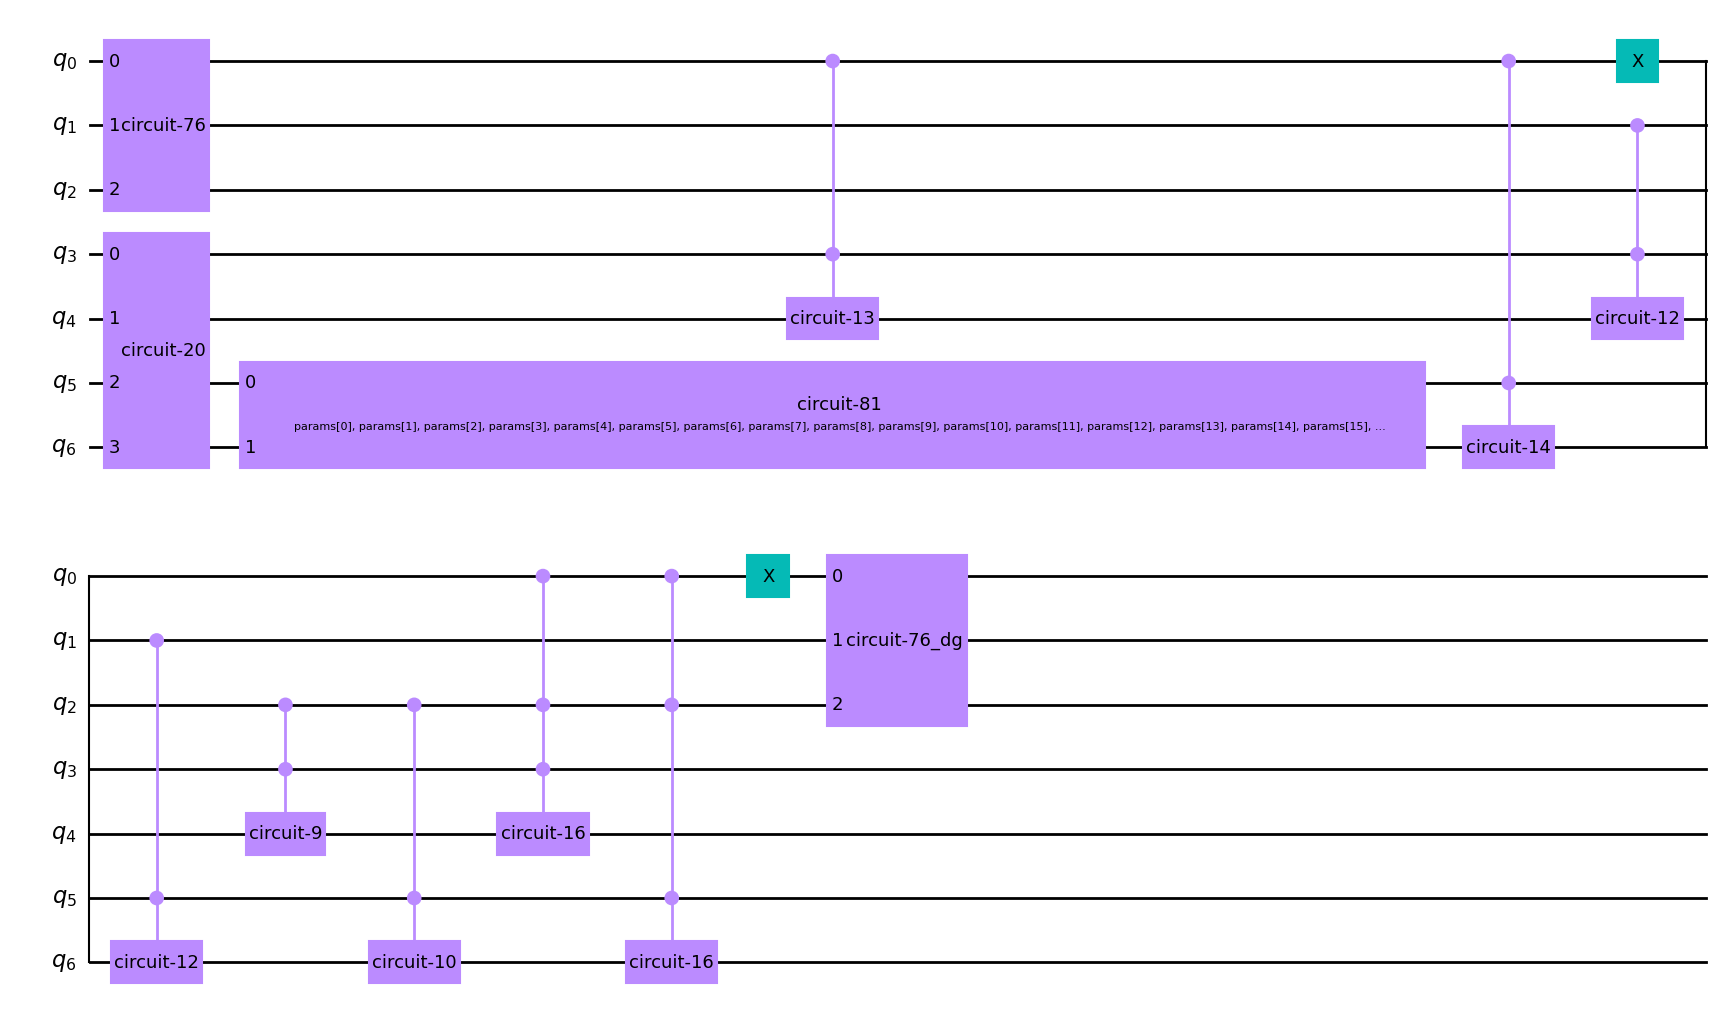

In [25]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

In [27]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19])])


In [28]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [30]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [31]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [32]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [33]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [34]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first three qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [35]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[1.10163327 2.02742232 5.55093493 5.21630159 3.37390763 6.26854005
 5.38309697 4.79427061 1.06013799 0.04489495 1.94389904 5.62540803
 5.44045608 0.9251606  5.72922422 1.84550872 0.41226689 0.4427797
 0.23888808 1.67896293]
Initial Cost :  0.3827827285339674


In [36]:
'''
True value calculated using the SDP.
'''
true_value = 0.75

In [88]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5266495016224061
Loss Value :  0.5075534196915391 1.0%
Loss Value :  0.5122494458654687 2.0%
Loss Value :  0.525512654654703 3.0%
Loss Value :  0.6022450574092587 4.0%
Loss Value :  0.609042986081934 5.0%
Loss Value :  0.639353506684086 6.0%
Loss Value :  0.6462081505656855 7.0%
Loss Value :  0.6527734456036647 8.0%
Loss Value :  0.6758585790985375 9.0%
Loss Value :  0.683470188854251 10.0%
Loss Value :  0.7010903667796584 11.0%
Loss Value :  0.7126774973645309 12.0%
Loss Value :  0.7133144366074221 13.0%
Loss Value :  0.7135170818553568 14.0%
Loss Value :  0.7212457768447165 15.0%
Loss Value :  0.7224262958267916 16.0%
Loss Value :  0.7236868326627711 17.0%
Loss Value :  0.7240255557942098 18.0%
Loss Value :  0.7302918529967842 19.0%
Loss Value :  0.7307584363620994 20.0%
Loss Value :  0.7320383240325813 21.0%
Loss Value :  0.7323861628056111 22.0%
Loss Value :  0.7366406085422313 23.0%
Loss Value :  0.7372094765622663 24.0%
Loss Value :  0.7372615636514408 25.0%
Los

In [89]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.330658015850489
Loss Value :  0.3679364108401783 1.0%
Loss Value :  0.37618510953505924 2.0%
Loss Value :  0.39175136621547785 3.0%
Loss Value :  0.348215770435159 4.0%
Loss Value :  0.3431312291764828 5.0%
Loss Value :  0.34697104776912197 6.0%
Loss Value :  0.38808619258447996 7.0%
Loss Value :  0.3809831801915333 8.0%
Loss Value :  0.4140434304981915 9.0%
Loss Value :  0.44128975918536123 10.0%
Loss Value :  0.42875923588289516 11.0%
Loss Value :  0.4267790432702033 12.0%
Loss Value :  0.42201568747605417 13.0%
Loss Value :  0.40937270846547047 14.0%
Loss Value :  0.44303125676344224 15.0%
Loss Value :  0.4136715670315879 16.0%
Loss Value :  0.4153237821449194 17.0%
Loss Value :  0.4514184384050823 18.0%
Loss Value :  0.4376681219116886 19.0%
Loss Value :  0.42197872325532143 20.0%
Loss Value :  0.43022503369043763 21.0%
Loss Value :  0.425448301228723 22.0%
Loss Value :  0.41844305035963836 23.0%
Loss Value :  0.42912395713799273 24.0%
Loss Value :  0.421983000111

In [90]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.7446594336813993


In [91]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.75
Noiseless :  0.749976646846372
Noisy :  0.45813385417783675
Noise Resilient Value :  0.7446594336813993


In [37]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("Q8_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [57]:
writeToFile()